In [5]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import swifter
import hashlib
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [7]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20231220'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-11-18' and '2023-11-24'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


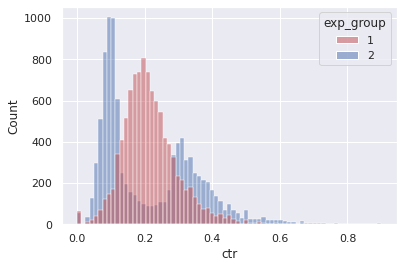

In [8]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

В обеих группах мы видим нормальное распределение, которые пересекаются. 

In [9]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Выборки равны

In [10]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
Отличие не прокрасилось
В 55.42 % случаев A > B. Должно получиться около 50%


 Мы исходим из предположения, что наш новый алгорим улучшает CTR. Если учитывать это при проверке Манна-Уитни, то мы не можем отвергнуть нулевую гипотезу и сказать, что в группе с новым алгоритмом CTR лучше.

In [11]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [12]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [13]:
group2 = df[df['exp_group'] == 2]
group1 = df[df['exp_group'] == 1]

/tmp/ipykernel_51/1526888802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
/tmp/ipykernel_51/1526888802.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.smothed_ctr, kde=False)


<Axes: xlabel='smothed_ctr'>

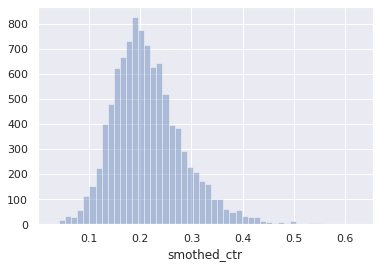

In [14]:
group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, kde=False)

/tmp/ipykernel_51/1770539221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['smothed_ctr'] = df.apply(
/tmp/ipykernel_51/1770539221.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.smothed_ctr, kde=False)


<Axes: xlabel='smothed_ctr'>

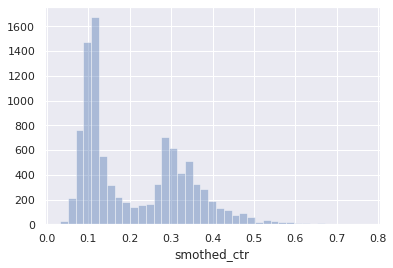

In [15]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, kde=False)

 После сглаживания CTR график контрольной группы (2) всё также с 2 горбами, график контрольной (1) - с одним.

In [16]:
stats.ttest_ind(group2['smothed_ctr'],
                group1['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=-1.9460491517027683, pvalue=0.05166679015318526)

Выборки равны

In [17]:
stats.mannwhitneyu(group2['smothed_ctr'],
                group1['smothed_ctr'], alternative='greater')


MannwhitneyuResult(statistic=43439187.0, pvalue=1.0)

Выборки равны

После сглаживания 2 теста опять показали, что выборки равны

In [18]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [19]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

<Axes: ylabel='Count'>

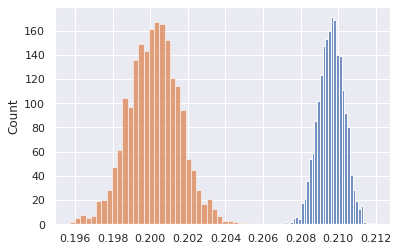

In [20]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

 По результатам Бутстрепа - глобальные ctr 2х групп не пересекаются

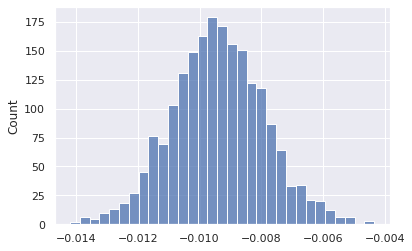

In [21]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1);

Гистограмма разницы CTR распределение не пересекает 0

In [22]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-11-18' and '2023-11-24'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_df = ph.read_clickhouse(q, connection=connection)

In [23]:
bucket_df.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.200592,0.305556
1,2,0,0.196510,0.385321
2,1,1,0.208799,0.311111
3,2,1,0.210375,0.485714
4,1,2,0.204632,0.314286


In [24]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(bucket_df[bucket_df['exp_group'] == 2].bucket_ctr, 
                   bucket_df[bucket_df['exp_group'] == 1].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=503.0, pvalue=2.6576427804010095e-07)

In [25]:
stats.mannwhitneyu(bucket_df[bucket_df['exp_group'] == 2].bucket_ctr, 
                   bucket_df[bucket_df['exp_group'] == 1].bucket_ctr, 
                   alternative = 'greater')

MannwhitneyuResult(statistic=503.0, pvalue=0.9999998719131218)

In [26]:
stats.mannwhitneyu(bucket_df[bucket_df['exp_group'] == 2].bucket_ctr, 
                   bucket_df[bucket_df['exp_group'] == 1].bucket_ctr, 
                   alternative = 'less')

MannwhitneyuResult(statistic=503.0, pvalue=1.3288213902005047e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

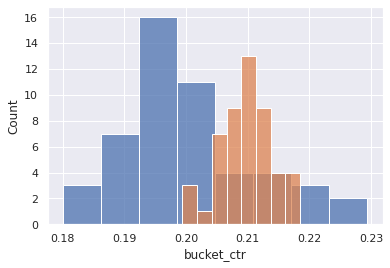

In [27]:
sns.histplot(bucket_df[bucket_df['exp_group'] == 2].bucket_ctr)
sns.histplot(bucket_df[bucket_df['exp_group'] == 1].bucket_ctr)

СTR показывает различные результаты при тестировании. В эксперминетальной группу на гистограммах мы выдим 2 горба (причем 1 меньше пика контрольной, а другой больше). Я бы не советовала выкатывать новый алгоритм на аудиторию, тк пока что о стабльных результатах увеличения взаимодействий пользователей от новвоведений в экмперементальной группе не замечено. То алгоритм показывает рост ctr, то, наоборот, показывает падение.

Следует алгоритм отправить разработчикам на 'починку' и в дальнейшем еще на А/Б тесты.